Import library, download dataset dan mengestrak dataset

In [1]:
# import library
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Dropout , Flatten, Dense, BatchNormalization
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
import zipfile,os

In [2]:
# dataset
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O rockpaperscissors.zip

--2021-06-04 12:56:54--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  2.14MB/s    in 3m 28s  

2021-06-04 13:00:23 (1.48 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [3]:
# ekstraksi dataset pada file zip
local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Memisahkan/membagi data (tanpa merusak struktur folder)

In [4]:
!pip install split_folders

In [5]:
import splitfolders

splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images','/tmp/rockpaperscissors', seed=1, ratio=(.6, .4)) #ratio=(train, val)

Copying files: 2188 files [00:00, 4057.86 files/s]


Membuat direktori

In [6]:
base_dir = '/tmp/rockpaperscissors'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [7]:
os.listdir(train_dir)

['scissors', 'rock', 'paper']

In [8]:
os.listdir(validation_dir)

['scissors', 'rock', 'paper']

In [9]:
# membuat direktori batu pada direktori data training
train_rock_dir = os.path.join(train_dir, 'rock')
 
 # membuat direktori gunting pada direktori data training
train_scissors_dir = os.path.join(train_dir, 'scissors')

# membuat direktori kertas pada direktori data training
train_paper_dir = os.path.join(train_dir, 'paper')

# membuat direktori batu pada direktori data validasi
validation_rock_dir = os.path.join(validation_dir, 'rock')
 
# membuat direktori gunting pada direktori data validasi
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

# membuat direktori kertas pada direktori data validasi
validation_paper_dir = os.path.join(validation_dir, 'paper')

Generate image data (augmentasi gambar dan preprocessing data)

In [10]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [11]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        # karena merupakan masalah klasifikasi 3 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32, 
        # karena merupakan masalah klasifikasi 3 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


Membangun arsitektur model dengan CNN

In [12]:
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True


model = models.Sequential()
model.add(conv_base)

model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(layers.Flatten())
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dense(3, activation='softmax')) #softmax digunakan karena untuk multi-class klasifikasi


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          1179712   
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 1, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                2

Compile model

In [13]:
# compile model dengan 'adam' optimizer loss function 'categorical_crossentropy' 
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Model training (pelatihan model)

In [14]:
# latih model dengan model.fit 
history = model.fit(
      train_generator,
      steps_per_epoch=20,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=10, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/10
20/20 - 230s - loss: 0.5522 - accuracy: 0.7906 - val_loss: 4.5369 - val_accuracy: 0.3187
Epoch 2/10
20/20 - 220s - loss: 0.2150 - accuracy: 0.9406 - val_loss: 1.7633 - val_accuracy: 0.6750
Epoch 3/10
20/20 - 223s - loss: 0.1628 - accuracy: 0.9625 - val_loss: 1.2054 - val_accuracy: 0.7375
Epoch 4/10
20/20 - 221s - loss: 0.1679 - accuracy: 0.9578 - val_loss: 0.4264 - val_accuracy: 0.7188
Epoch 5/10
20/20 - 219s - loss: 0.0551 - accuracy: 0.9828 - val_loss: 0.0510 - val_accuracy: 0.9750
Epoch 6/10
20/20 - 219s - loss: 0.0627 - accuracy: 0.9797 - val_loss: 0.0130 - val_accuracy: 0.9875
Epoch 7/10
20/20 - 219s - loss: 0.0352 - accuracy: 0.9891 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 8/10
20/20 - 223s - loss: 0.1035 - accuracy: 0.9812 - val_loss: 0.2987 - val_accuracy: 0.9563
Epoch 9/10
20/20 - 223s - loss: 0.1947 - accuracy: 0.9531 - val_loss: 0.0869 - val_accuracy: 0.9750
Epoch 10/10
20/20 - 220s - loss: 0.0820 - accuracy: 0.9734 - val_loss: 0.0183 - val_accuracy: 0.9937

Visualisasi Data Training Loss dan Validation Loss

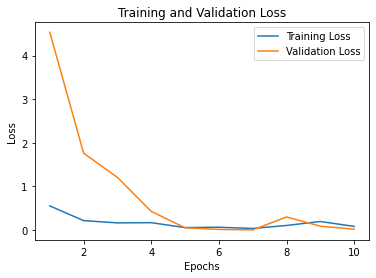

In [15]:
from matplotlib import pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train,  label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Visualisasi Data Training Accuracy dan Validation Accuracy

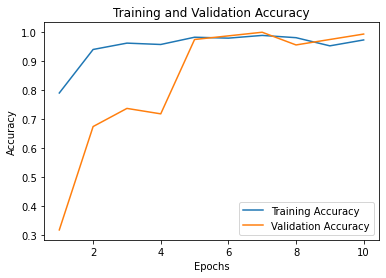

In [16]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, label='Training Accuracy')
plt.plot(epochs, loss_val, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Prediksi gambar kertas, batu, dan gunting untuk mengetes model

Saving 20210604_184312.jpg to 20210604_184312.jpg
20210604_184312.jpg
scissors


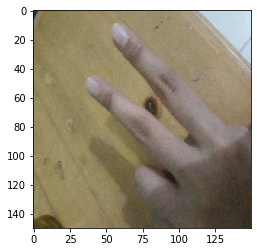

In [17]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0,0]!=0:
    print('paper')
  elif classes[0,1]!=0:
    print('rock')
  else:
    print('scissors')

Data Diri

Nama    : Nadya Novalina

email   : nadyanovalina@gmail.com